In [95]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        output = self.out(output[0]) 
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
def oneHot(idx):
    x = torch.zeros(10).float()
    x[idx] = 1.0
    return x

# input_data = list(zip(range(0,8),range(1,9)))+[[8,9],[9,0]]
# output_data = list(range(2,10))+[0,1]

input_data = list(zip(range(0,8),range(1,9)))
output_data = list(range(2,10))
pairs= list(zip(input_data,output_data))

def tensorsFromPair(pair):
    input_tensor = torch.tensor(pair[0], dtype=torch.long, device=device).view(-1, 1)
    target_tensor = torch.tensor(pair[1], dtype=torch.long, device=device).view(-1, 1)
    return (input_tensor, target_tensor)

input_size, hidden_size = 10, 2
n_iters = 1
encoder = EncoderRNN(input_size, hidden_size).to(device)
learning_rate = 0.05

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
encoder_hidden = encoder.initHidden()
criterion = nn.NLLLoss()

A=[]
for epoch in range(100):
    training_pairs = [tensorsFromPair(pair) for pair in pairs]
    a=0
    for _ in range(len(training_pairs)):
        i = random.choice(range(8))
        loss = 0
        training_pair = training_pairs[i]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        encoder_optimizer.zero_grad()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        for ei in range(2):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        loss += criterion(encoder_output, target_tensor[0])

        loss.backward(retain_graph=True)
        encoder_optimizer.step()
        a+=loss.item()
    A.append(a/n_iters)
    if epoch%10==0:
        print(epoch,a/n_iters)
    
    


0 20.29178738594055
10 18.157113194465637
20 17.455609679222107
30 16.499610781669617
40 15.60313868522644
50 15.89236831665039
60 14.15184736251831
70 12.326170325279236
80 10.348144292831421
90 9.535945057868958


In [93]:
for epoch in range(100):
    training_pairs = [tensorsFromPair(pair) for pair in pairs]
    a=0
    for _ in range(len(training_pairs)):
        i = random.choice(range(8))
        loss = 0
        training_pair = training_pairs[i]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        encoder_optimizer.zero_grad()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        for ei in range(2):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        loss += criterion(encoder_output, target_tensor[0])

        loss.backward(retain_graph=True)
        encoder_optimizer.step()
        a+=loss.item()
    A.append(a/n_iters)
    if epoch%10==0:
        print(epoch,a/n_iters)
    

0 1.975058126449585
10 1.9347392082214356
20 1.903801727294922
30 1.8754781246185304
40 1.8493281364440919
50 1.8249556064605712
60 1.8019652843475342
70 1.779932165145874
80 1.7583593845367431
90 1.7366591453552247


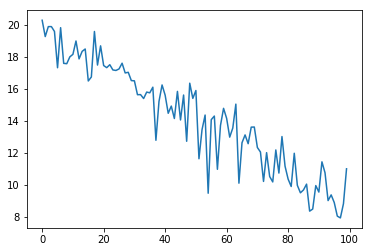

In [96]:
import matplotlib.pyplot as plt
plt.plot(A)
plt.show()

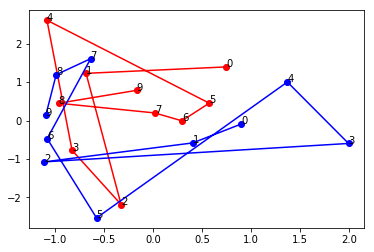

In [97]:
W1 = encoder.embedding.weight.data.numpy()
x, y = W1[:,0],W1[:,1]
plt.plot(x,y,'ro-')
for  i in range(10):
    plt.text(x[i],y[i],str(i))


W2 = encoder.out.weight.data.numpy().T
x, y = W2[0,:],W2[1,:]
plt.plot(x,y,'bo-')
for  i in range(10):
    plt.text(x[i],y[i],str(i))
#plt.savefig('dafengche.png')


In [98]:
training_pairs = [tensorsFromPair(pairs[i]) for i in range(8)]
a=0
for i in range(8):
    training_pair = training_pairs[i]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    print(input_tensor.tolist())
    for ei in range(2):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    print("pred:",encoder_output.topk(1)[1].item(),"true:", target_tensor[0].item())

[[0], [1]]
pred: 2 true: 2
[[1], [2]]
pred: 3 true: 3
[[2], [3]]
pred: 4 true: 4
[[3], [4]]
pred: 5 true: 5
[[4], [5]]
pred: 9 true: 6
[[5], [6]]
pred: 8 true: 7
[[6], [7]]
pred: 8 true: 8
[[7], [8]]
pred: 9 true: 9


In [77]:
W2.T

TypeError: 'numpy.ndarray' object is not callable